<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/W1_2_Data_CosmicStringCusps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install pycbc:

In [3]:
pip install pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━

In [4]:
! pip install -q lalsuite pycbc


#Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftfreq, ifft
from scipy.signal import spectrogram
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


#LIGO Noise

In [148]:

# Parameters as in the paper "Gravitational-Wave Searches for Cosmic String Cusps in Einstein Telescope Data using Deep Learning" by Meijer
sample_rate = 8192
delta_t = 1 / sample_rate
noise_dur = 1.0
noise_samples = int(noise_dur * sample_rate)

#########
psd = aLIGOZeroDetHighPower(noise_samples // 2 + 1, delta_f=1.0 / noise_dur, low_freq_cutoff=30)
noise = noise_from_psd(noise_samples, delta_t, psd, seed=42)


#Generate Cosmic String Cusps signal:

In [153]:
from numpy.fft import fftfreq, ifft
from scipy.signal import spectrogram

# Signal parameters
signal_dur = 0.01
snr_target = 5

#########################
def cusp_signal(amplitude=1.0, f_high=512, delta_t=1/8192, duration=0.01):
    fs = 1 / delta_t
    N = int(duration * fs)
    freqs = fftfreq(N, d=delta_t)
    h_f = np.zeros(N, dtype=complex)
    pos_mask = freqs > 0
    f_pos = freqs[pos_mask]
    spectrum = f_pos**(-4/3)
    spectrum[f_pos >= f_high] *= np.exp(1 - f_pos[f_pos >= f_high] / f_high)
    h_f[pos_mask] = amplitude * spectrum
    h_f = h_f + np.conj(h_f[::-1])
    h_f *= np.exp(-2j * np.pi * freqs * (duration / 2))
    h_t = ifft(h_f).real
    t = np.linspace(0, duration, N, endpoint=False)
    return t, h_t


t_sig, signal = cusp_signal(delta_t=delta_t, duration=signal_dur)

#######################
# Normalize and scale by SNR!!!!
signal /= np.sqrt(np.mean(signal**2))  # Normalize RMS
noise_rms = np.sqrt(np.mean(noise**2))
signal *= snr_target * noise_rms

# signal + noise at center
strain = noise.copy()
start = (len(noise) - len(signal)) // 2
strain[start:start+len(signal)] += signal

# For plotting: zero-padded signal
signal_full = np.zeros_like(strain)
signal_full[start:start+len(signal)] = signal
t = np.linspace(0, noise_dur, noise_samples)


#Plot


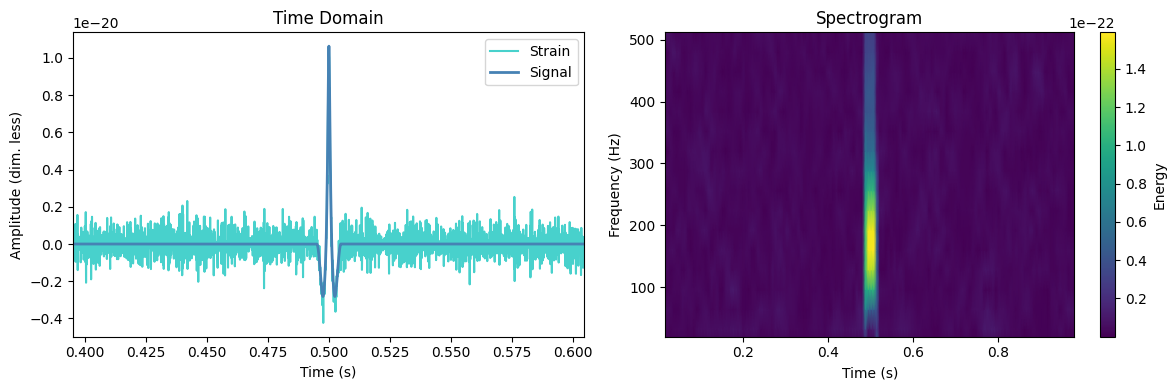

In [154]:
f, t_spec, Sxx = spectrogram(strain, fs=sample_rate, nperseg=256, noverlap=200)
Sxx_dB = np.sqrt(Sxx)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})

#Time domain
axs[0].plot(t, strain, label='Strain', color='mediumturquoise')
axs[0].plot(t, signal_full, label='Signal', color='steelblue', linewidth=2)
axs[0].set_xlim(start/sample_rate - 0.1, (start + len(signal))/sample_rate + 0.1)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude (dim. less)")
axs[0].legend()
axs[0].set_title("Time Domain")

#Spectrogram
axs[1].pcolormesh(t_spec, f, Sxx_dB, shading='gouraud', cmap='viridis')
axs[1].set_ylim(20, 512)
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Spectrogram")
plt.colorbar(axs[1].collections[0], ax=axs[1], label='Energy')

plt.tight_layout()
plt.show()
